In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree, export_graphviz
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

import graphviz

In [24]:
hsc_kb = pd.read_csv(r"data\datos_hsc_humad_limpios.csv", delimiter=';')
hsc_kb.shape

(127, 82)

In [25]:
#vamos a guardar la ultima fila de nuesro dataframe para una prueba
ultima_fila = hsc_kb.iloc[-1].copy()
hsc_kb = hsc_kb.iloc[:-1].copy()
hsc_kb.shape

(126, 82)

In [26]:
#vamos a preparar nuestro arbol para que prediga si habrá o no recurrencia de hematoma, eliminemos variables posoperatorias
columnas_eliminar = [' ESTADO AL EGRESO', 'escala_resultados_glasgow']

for e in columnas_eliminar:
    hsc_kb = hsc_kb.drop(e, axis=1)
hsc_kb.head()

hsc_kb.shape

(126, 80)

In [27]:
#vamos a preparar los datos de entrenamiento
x = hsc_kb.drop(' REINTERVENCIÓ0N', axis=1)
y = hsc_kb[' REINTERVENCIÓ0N']

#dividimos entrenamiento y prueba (70-30)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Mostrar distribución original
print("Distribución original en entrenamiento:\n", y_train.value_counts())
print("\nDistribución original en prueba:\n", y_test.value_counts())

## Opción 1: Usando SMOTE para balancear las clases
print("\n=== Resultados con SMOTE ===")
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

print("\nDistribución después de SMOTE:\n", y_train_smote.value_counts())

Distribución original en entrenamiento:
  REINTERVENCIÓ0N
0.0    73
1.0    15
Name: count, dtype: int64

Distribución original en prueba:
  REINTERVENCIÓ0N
0.0    33
1.0     5
Name: count, dtype: int64

=== Resultados con SMOTE ===

Distribución después de SMOTE:
  REINTERVENCIÓ0N
0.0    73
1.0    73
Name: count, dtype: int64


In [28]:
# Crear y entrenar modelo con datos balanceados
modelo_smote = RandomForestClassifier(n_estimators=2, max_depth=5, random_state=42, n_jobs=-1)
modelo_smote.fit(x_train_smote, y_train_smote)

# Predecir y evaluar
y_pred_smote = modelo_smote.predict(x_test)
print("\nExactitud con SMOTE: ", accuracy_score(y_test, y_pred_smote))
print("\nReporte de clasificación con SMOTE:\n", classification_report(y_test, y_pred_smote))

## Opción 2: Usando class_weight en Random Forest
print("\n=== Resultados con class_weight ===")
modelo_weight = RandomForestClassifier(n_estimators=2, max_depth=5, random_state=42, 
                                     n_jobs=-1, class_weight="balanced")
modelo_weight.fit(x_train, y_train)

y_pred_weight = modelo_weight.predict(x_test)
print("\nExactitud con class_weight: ", accuracy_score(y_test, y_pred_weight))
print("\nReporte de clasificación con class_weight:\n", classification_report(y_test, y_pred_weight))


Exactitud con SMOTE:  0.8157894736842105

Reporte de clasificación con SMOTE:
               precision    recall  f1-score   support

         0.0       0.86      0.94      0.90        33
         1.0       0.00      0.00      0.00         5

    accuracy                           0.82        38
   macro avg       0.43      0.47      0.45        38
weighted avg       0.75      0.82      0.78        38


=== Resultados con class_weight ===

Exactitud con class_weight:  0.8947368421052632

Reporte de clasificación con class_weight:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94        33
         1.0       1.00      0.20      0.33         5

    accuracy                           0.89        38
   macro avg       0.95      0.60      0.64        38
weighted avg       0.91      0.89      0.86        38



In [35]:
#vamos a determinar cuales son los parámetros optimos para el bosque aleatorio
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': list(range(1, 101)),       # Número de árboles
    'max_depth': list(range(1, 10)) + [None],        # Profundidad máxima
    'min_samples_split': list(range(2, 11)),     # Mínimo muestras para dividir un nodo
    'min_samples_leaf': list(range(1, 5)),       # Mínimo muestras en hojas
    'class_weight': ['balanced']  # Pesos de clase
}
# Crear el modelo base
modelo = RandomForestClassifier(random_state=42, n_jobs=-1)

# Configurar GridSearchCV
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='recall',  # También puedes usar 'recall' para la clase minoritaria. "accuracy"
    cv=5,               # Validación cruzada de 5 folds
    verbose=2,          # Muestra progreso detallado
    n_jobs=-1           # Paralelizar en todos los cores
)

# Ejecutar la búsqueda
# Cuidado al descomentar la ejecución de la busqueda es un proceso que en un microprocesador corei3 10th tomó 4 horas
#grid_search.fit(x_train, y_train)

# Mejores parámetros encontrados
print("\n=== Mejores hiperparámetros ===")
print(grid_search.best_params_)

# Evaluar el mejor modelo en el test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print("\nExactitud con mejores parámetros:", accuracy_score(y_test, y_pred))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 36000 candidates, totalling 180000 fits

=== Mejores hiperparámetros ===
{'class_weight': 'balanced', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1}

Exactitud con mejores parámetros: 0.7105263157894737

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0       0.89      0.76      0.82        33
         1.0       0.20      0.40      0.27         5

    accuracy                           0.71        38
   macro avg       0.55      0.58      0.54        38
weighted avg       0.80      0.71      0.75        38



D:\Universidad\Tesis\HSC-Studio\Backend HSCStudio\django_venv\Lib\site-packages\sklearn\tree\_export.py:673: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  ann.update_bbox_position_size(renderer)
D:\Universidad\Tesis\HSC-Studio\Backend HSCStudio\django_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


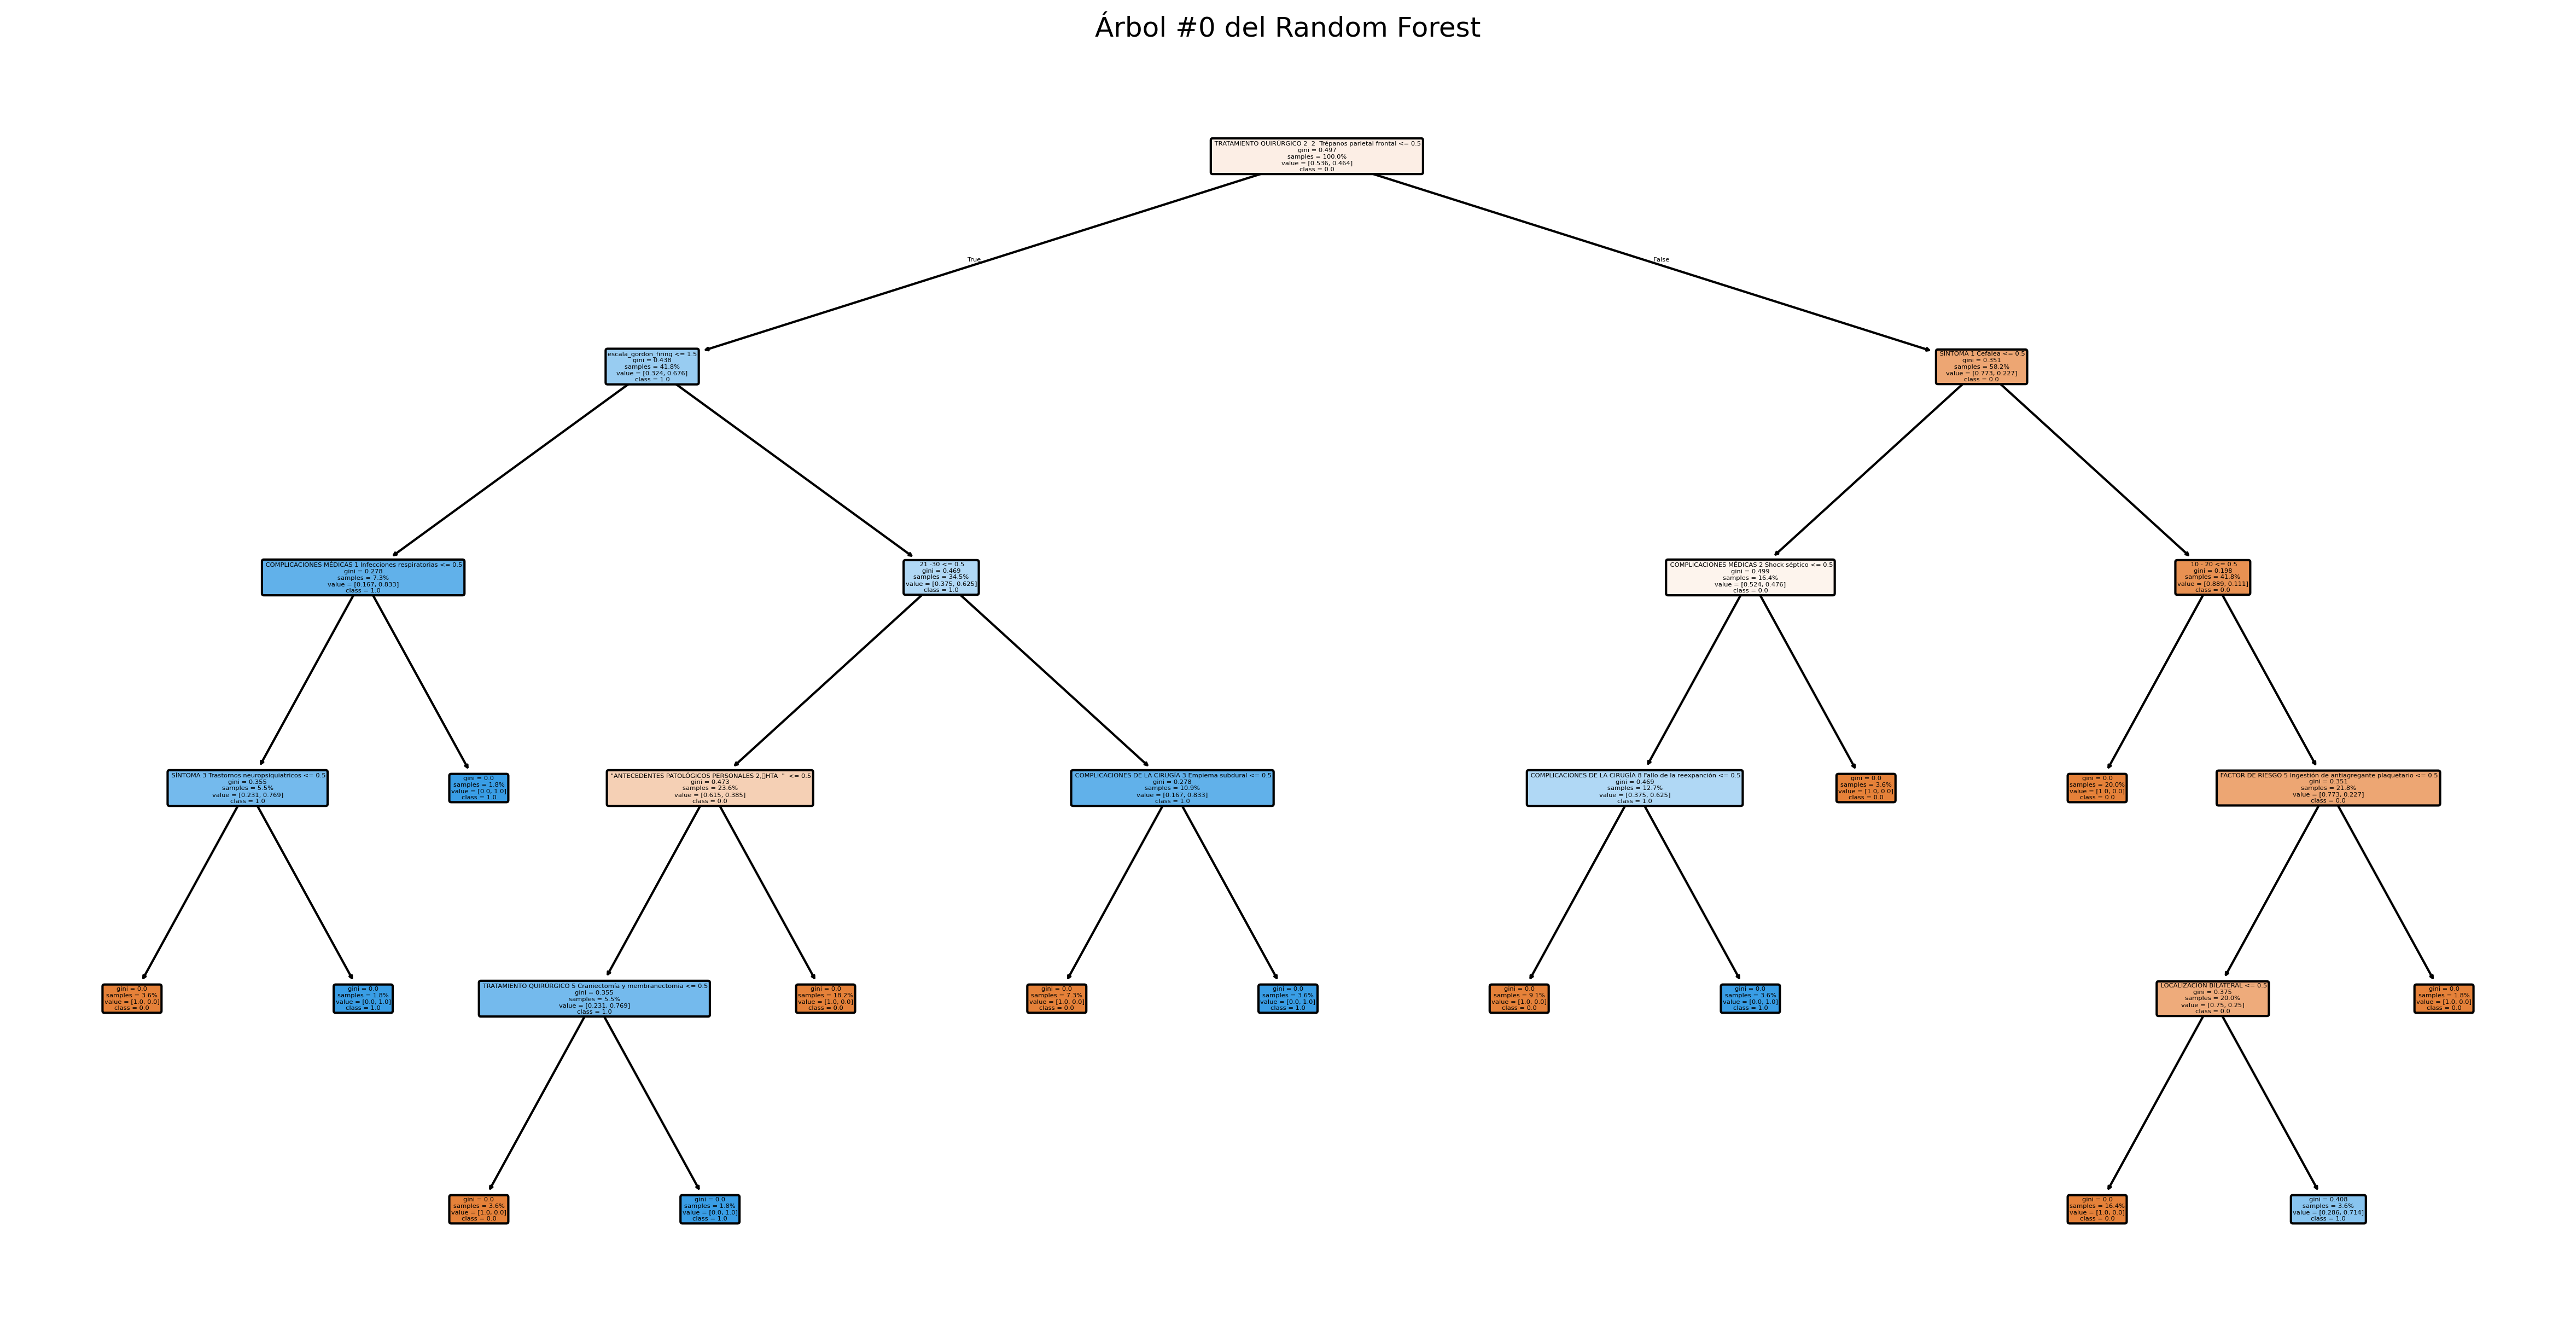

In [29]:
#veamos el primer arbol del bosque pasando el elemento a predecir que nos guardamos
plt.figure(figsize=(20, 10), dpi=300)

arbol_0 = modelo.estimators_[0]
plot_tree(
    arbol_0,
    feature_names=x_train.columns,  # Nombres de las features
    class_names=[str(cls) for cls in modelo.classes_],    # Nombres de las clases (para clasificación)
    filled=True,                   # Colorear por clase
    rounded=True,
    proportion=True,
    max_depth=10,
)
plt.title("Árbol #0 del Random Forest", fontsize=12)
plt.show()